<a href="https://colab.research.google.com/github/whyrachit/whyrachit-Sentiment-Analysis-Using-RNN/blob/main/Sentiment_Analysis_(Using_RNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (Dense, SimpleRNN, Input, Embedding, TextVectorization, Bidirectional, LSTM, GRU, Dropout)
from tensorflow.keras.optimizers import Adam

In [2]:
BATCH_SIZE=64

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

In [4]:
def standardization(input_data):

    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [5]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [6]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [7]:
training_data=train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [8]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [9]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [10]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Simple RNN Modeling

In [11]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)

In [12]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5007 - loss: 0.6961 - val_accuracy: 0.5099 - val_loss: 0.6927
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5769 - loss: 0.6793 - val_accuracy: 0.5537 - val_loss: 0.6713
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7015 - loss: 0.6084 - val_accuracy: 0.7538 - val_loss: 0.5672
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.7909 - loss: 0.5177 - val_accuracy: 0.8049 - val_loss: 0.5038
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8470 - loss: 0.4247 - val_accuracy: 0.7351 - val_loss: 0.6019
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8696 - loss: 0.3688 - val_accuracy: 0.8187 - val_loss: 0.4596
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8705 - loss: 0.3549 - val_accuracy: 0.8162 - val_loss: 0.4584
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9077 - loss: 0.2789 - 

In [16]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9463 - loss: 0.1920


[0.19219380617141724, 0.9467999935150146]

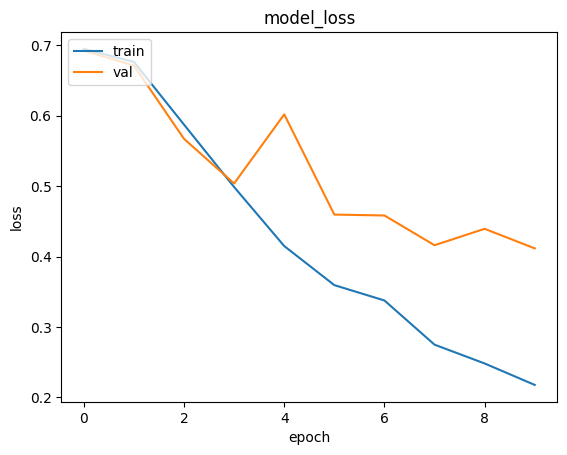

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is learning well on the training data, but the fluctuations in validation loss suggest possible overfitting.

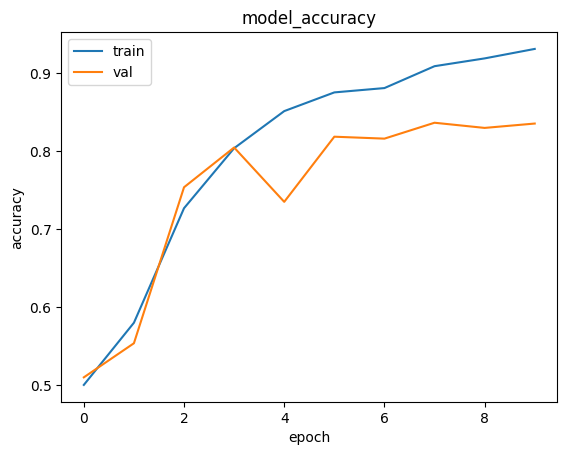

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is generalizing fairly well to the validation data, but the gap between training and validation accuracy after a few epochs indicates overfitting. The fluctuations in validation accuracy also reinforce the observation of potential overfitting.

## LSTM (Multilayer and Bidirectional) Modeling

In [19]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.5326 - loss: 0.6856 - val_accuracy: 0.8087 - val_loss: 0.4325
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8387 - loss: 0.3900 - val_accuracy: 0.8602 - val_loss: 0.3352
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8990 - loss: 0.2662 - val_accuracy: 0.8659 - val_loss: 0.3564
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9243 - loss: 0.2163 - val_accuracy: 0.8654 - val_loss: 0.4201
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9358 - loss: 0.1903 - val_accuracy: 0.8490 - val_loss: 0.4334
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9370 - loss: 0.1837 - val_accuracy: 0.8532 - val_loss: 0.3837
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9405 - loss: 0.1678 - val_accuracy: 0.8509 - val_loss: 0.4131
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9537 - loss: 0.1405 - 

In [23]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8426 - loss: 0.5282


[0.5189847946166992, 0.8471199870109558]

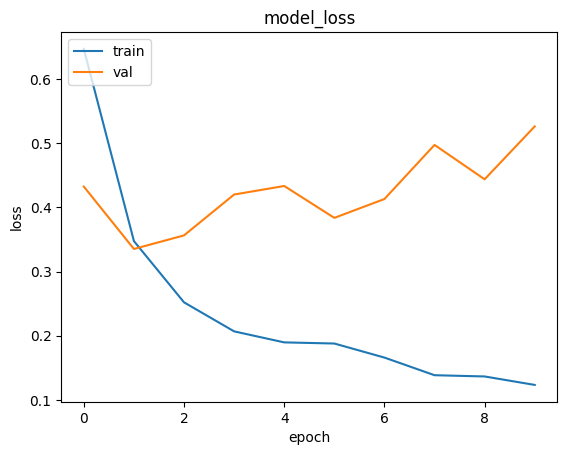

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model begins to overfit after the second epoch. Overfitting means the model performs well on the training data but less so on unseen validation data.

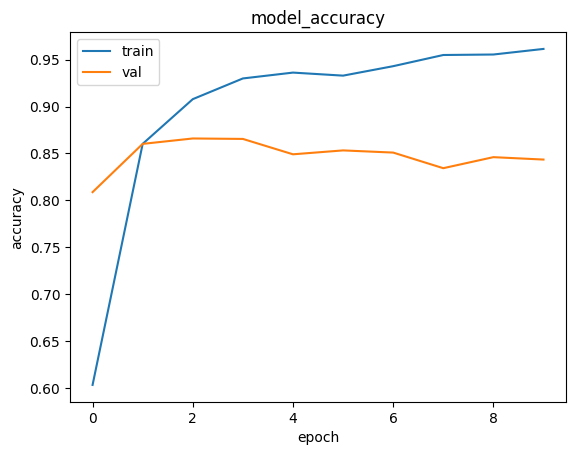

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model's generalization on unseen data is decent but doesn't improve after the first few epochs, again suggesting potential overfitting.

## GRU (Multilayer and Bidirectional) Modeling

In [26]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 250, 128)            │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.5222 - loss: 0.6922 - val_accuracy: 0.6184 - val_loss: 0.6627
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7412 - loss: 0.5248 - val_accuracy: 0.8139 - val_loss: 0.4126
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8640 - loss: 0.3416 - val_accuracy: 0.8290 - val_loss: 0.3998
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8932 - loss: 0.2851 - val_accuracy: 0.8333 - val_loss: 0.4045
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.9170 - loss: 0.2364 - val_accuracy: 0.8518 - val_loss: 0.3774
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9357 - loss: 0.1904 - val_accuracy: 0.8458 - val_loss: 0.4157
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9461 - loss: 0.1687 - val_accuracy: 0.8394 - val_loss: 0.4465
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9384 - loss: 0.1758 - 

In [30]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8273 - loss: 0.4942


[0.49731743335723877, 0.8235999941825867]

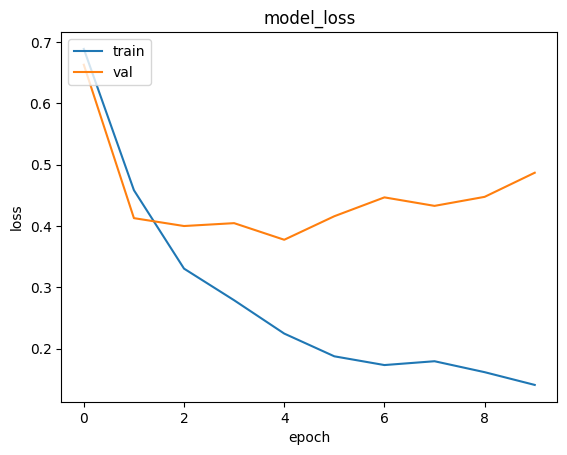

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model initially generalizes fairly well to the validation data, the increasing gap between training and validation loss after the early epochs points to overfitting.

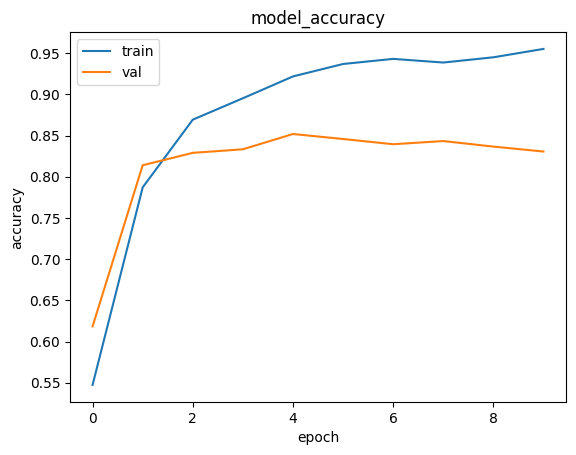

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model learns well during the early epochs, but starting from around epoch 4, the validation accuracy plateaus while the training accuracy keeps improving, implying overfitting